## Working with the brige from previous task(C60)

In [2]:
import xml.etree.ElementTree as ET
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import trimesh
import open3d as o3d
import matplotlib.pyplot as plt
from data_load import correct_meshroom_extrinsics, get_image_data_from_json, get_camera_intrinsics_from_json
from mesh_utils import slice_mesh_with_fuse, create_masks_from_meshes, draw_mask_on_img
from visualisation import visualize_results, visualize_results_interactive

def rotation_matrix_to_euler_angles(R):
    """Converts a rotation matrix to Euler angles (yaw, pitch, roll)."""

    sy = np.sqrt(R[0, 0] ** 2 + R[1, 0] ** 2)
    singular_case = sy < 1e-6

    if not singular_case:
        yaw = np.arctan2(R[1, 0], R[0, 0])
        pitch = -np.arcsin(R[2, 0])
        roll = np.arctan2(R[2, 1], R[2, 2])
    else:
        yaw = np.arctan2(-R[1, 2], R[0, 2])
        pitch = np.pi / 2 if R[2, 0] > 0 else -np.pi / 2
        roll = 0

    return yaw, pitch, roll

plt.rcParams['figure.figsize'] = [12.5, 7.5]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [9]:
IMAGE_PATH = "../Bridge-Seg/data/Step_B_C60/RawImages/DJI_20240130130940_0036.JPG"
JSON_PATH = '../Bridge-Seg/data/Step_B_C60/sfm.json'
MESH_PATH = "/home/teshbek/Work/Bridges_Project/Bridge-Seg/data/Step_B_C60/C60_scaled_cleaned.obj"


image_name = IMAGE_PATH.split('/')[-1]
_, _, _, _, rotation, center = get_image_data_from_json(image_name, JSON_PATH)
camera_matrix, dist_coeffs = get_camera_intrinsics_from_json(image_name, JSON_PATH)

rotation = np.array(rotation, dtype=np.float32).reshape(3, 3).transpose()
center = np.array(center, dtype=np.float32).reshape(3, 1)
rotation, center = correct_meshroom_extrinsics(rotation, center)


meshes = []
world_xyz = trimesh.creation.axis()
meshes.append(world_xyz)
camera_xyz = trimesh.creation.axis()
camera_xyz.vertices = (np.matmul(rotation.transpose(), camera_xyz.vertices.transpose()) + center).transpose()
meshes.append(camera_xyz)
pier = trimesh.load(MESH_PATH, force='mesh')
pier_cutted = slice_mesh_with_fuse(rotation, center, camera_matrix, 8192, 5460, pier)
meshes.append(pier_cutted)

scene = trimesh.Scene(meshes)
scene.show('notebook')


/home/teshbek/miniconda3/envs/torch_env/lib/python3.11/site-packages/trimesh/grouping.py:99: RuntimeWarning: invalid value encountered in cast
  stacked = np.column_stack(stacked).round().astype(np.int64)


Above is visible from the camera part of the mesh 

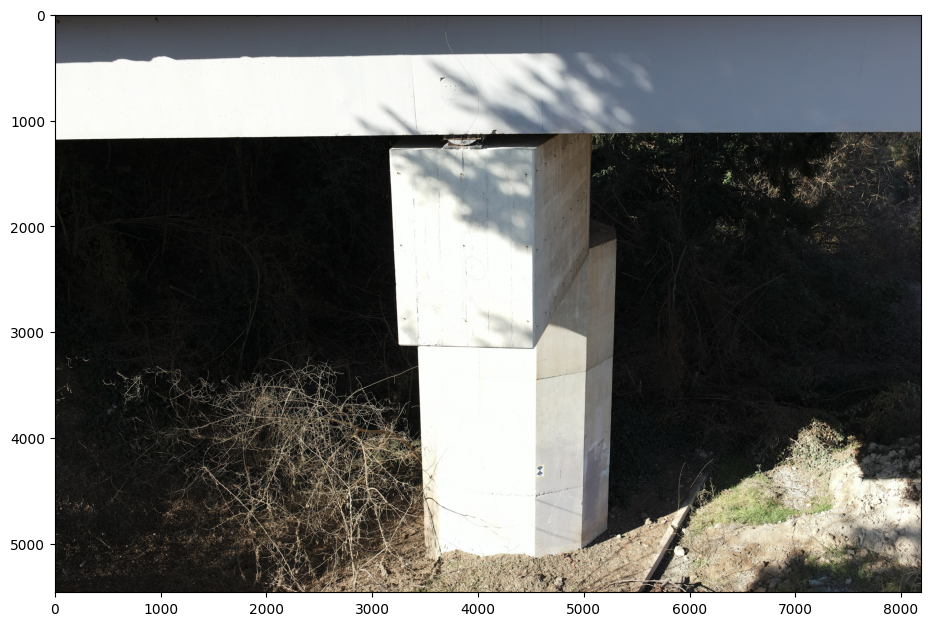

In [10]:
#camera view
img = cv.imread(IMAGE_PATH)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img) 
plt.show()

Ray casting approach

In [11]:
image_shape = (img.shape[0], img.shape[1])  # (height, width) of the image

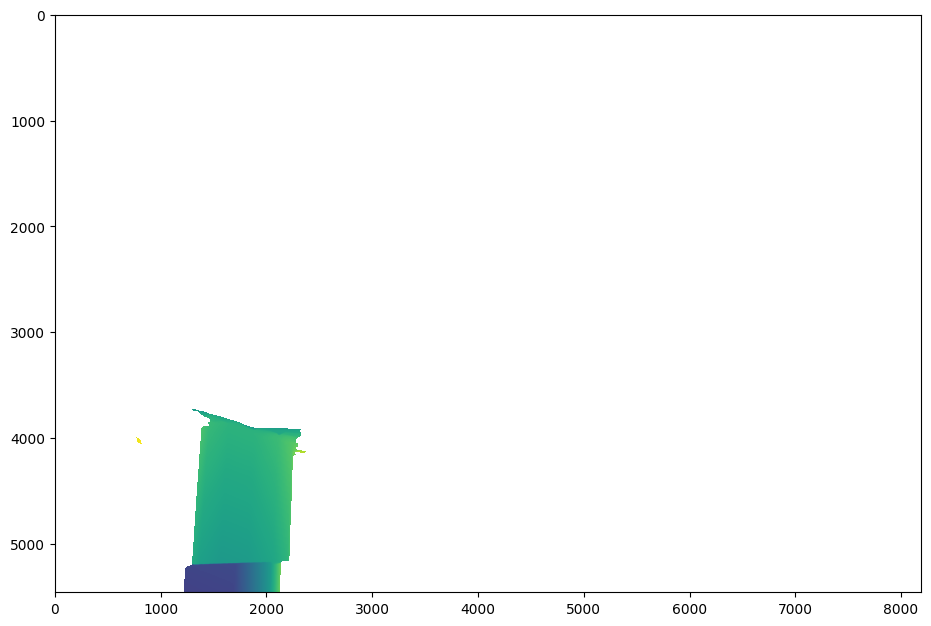

In [12]:
# open3d approach

def render_depth(
    intrins:o3d.core.Tensor,
    width:int,
    height:int,
    extrins:o3d.core.Tensor,
    tmesh:o3d.t.geometry.TriangleMesh
)->np.ndarray:
    
    scene = o3d.t.geometry.RaycastingScene()
    scene.add_triangles(tmesh)
    rays = scene.create_rays_pinhole(
        intrinsic_matrix=intrins,
        extrinsic_matrix=extrins,
        width_px=width, height_px=height
    )
    ans = scene.cast_rays(rays)
    t_hit = ans["t_hit"].numpy()
    return t_hit


mesh_path = '/home/teshbek/Work/Bridges_Project/Bridge-Seg/data/Step_B_C60/C60_scaled_cleaned.obj'
mesh = o3d.t.io.read_triangle_mesh(mesh_path)
mesh.compute_vertex_normals()
width_  =  img.shape[1]
height_ = img.shape[0]
# root2cam 4x4
extrens = np.eye(4)
extrens[:3, :3] = rotation
extrens[:3, 3] = np.squeeze(center)

intrins_t = o3d.core.Tensor(camera_matrix)
extrins_t = o3d.core.Tensor(extrens)

rendered_depth = render_depth(
    intrins=intrins_t, 
    width=width_, 
    height=height_, 
    extrins = extrins_t, 
    tmesh=mesh
)

plt.imshow(rendered_depth)
plt.show()

same picture but in 3d 

not all visible verticies are selected